# Playlist continuation AI

This project aims to replicate the playlist continuation feature on the music streaming platform Spotify.

A brief dataset description, as well as all the steps taken during development are described and shown bellow.

Doubts and sugestion, contact me via <a href="mailto:gupaulasan@gmail.com?subject= Playlist Continuation">email</a> or <a href="https://www.linkedin.com/in/gustavopsantos/">LinkedIn</a>.

## Imports

In [1]:
import json
import os
import re
import random
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dot, Dropout, Embedding, Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [2]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def matrixFactorization(n_plists, n_tracks, n_factors=2):
  """Define a arquitura usada para fatoração matricial"""


  x = Input(shape=(2,), name='input_playlist_track')
  input1 = Lambda(lambda x: x[:, 0], name='input_playlist')(x)
  input2 = Lambda(lambda x: x[:, 1], name='input_track')(x)

  latent1 = Embedding(n_plists, n_factors, name='latent_playlist')(input1)
  latent2 = Embedding(n_tracks, n_factors, name='latent_track')(input2)
  y = Dot(axes=1)([latent1, latent2])

  model = Model(inputs=x, outputs=y)
  return model

def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[.,#!$%\^\*;:{}=\_`~()@]", ' ', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

## Dados

Os dados têm origem no dataset chamado Million Playlist Dataset (MPD), disponibilizado pelo Spotify em um desafio da conferência RecSys.

Mais informações sobre o desafio e o local para download dos dados podem ser encontrados neste link: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge, mediante cadastro na plataforma.

Os dados são disponilibilizados em formato JSON sendo que as 1.000.000 de playlists estão divididas em 1000 arquivos de 1000 playlists cada.

Para efeito de reduzir a complexidade e o tempo necessário para treinamento, usarei um subset de playlists, isto é, um número menor de playlists para treinamento

### Extração de dados

In [ ]:
dir = "/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/raw/subset_10_000"

rows = []
for arquivo in tqdm(os.listdir(dir)):
  if arquivo.endswith(".json"):
    with open(os.path.join(dir, arquivo), "r") as f:
      data = json.load(f)
      for playlist in data["playlists"]:
        pid = playlist['pid']
        name = playlist['name']
        tracks = playlist['tracks']
        for track in tracks:
            track_uri = track['track_uri']
            track_uri = track_uri.split(':')[-1] #Seleciona a parte única do ID
            artist_uri = track['artist_uri']
            artist_uri = artist_uri.split(':')[-1] #Seleciona a parte única do ID
            row = {
                'pid': pid,
                'plist_name': name,
                'track_uri': track_uri,
                'artist_uri': artist_uri
            }
            rows.append(row)

df = pd.DataFrame(rows)

raw_destination = "/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/raw/subset_10_000/subset_10_000df.pkl"
df.to_pickle(raw_destination)

100%|██████████| 11/11 [00:28<00:00,  2.55s/it]


In [ ]:
df.head()

,pid,plist_name,track_uri,artist_uri
0,0,Throwbacks,0UaMYEvWZi0ZqiDOoHU3YI,2wIVse2owClT7go1WT98tk
1,0,Throwbacks,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4
2,0,Throwbacks,0WqIKmW4BTrj3eJFmnCKMv,6vWDO969PvNqNYHIOW5v0m
3,0,Throwbacks,1AWQoqb9bSvzTjaLralEkT,31TPClRtHm23RisEBtV3X7
4,0,Throwbacks,1lzr43nnXAijIGYnCT8M8H,5EvFsr3kj42KNv97ZEnqij


Realizou-se a extração dos dados, originalmente em arquivos `.json`, para um dataframe com as colunas: `pid`, `plist_name`, `track_uri` e `artist_uri`

### Exploração de dados

In [ ]:
raw_destination = "/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/raw/subset_10_000/subset_10_000df.pkl"
df = pd.read_pickle(raw_destination)

Abaixo, verificou-se a quantidade de entradas únicas para cada uma das colunas do dataframe.

Observaram-se:

10.000 playlists distintas<br>
5.954 nomes de playlist distintos<br>
170.089 músicas distintas<br>
35.892 artistas distintos<br>

In [ ]:
df.nunique()

pid            10000
plist_name      5954
track_uri     170089
artist_uri     35892
dtype: int64

#### Aparições mínimas

Para efeito de funcionalidade dos modelos que serão utilizados, faz-se necessário que cada música presente no dataset apareça um número mínimo de vezes.

Abaixo, avaliou-se a quantidade de vezes que cada música aparece no subconjunto utilizado.

In [ ]:
df.value_counts('track_uri')

track_uri
7KXjTSCq5nL1LoYtL7XAwS    468
7BKLCZ1jbUBVqRi2FVlTVw    459
1xznGGDReH1oQq0xzbwXa3    425
7yyRTcZmCiyzzJlNzGC9Ol    402
3a1lNhkSLSkpJE4MSHpDu9    391
                         ... 
3Al9LK7gVFaFvrgMacHr5S      1
3AkyQA5WWh5jR4XrUIs4Ur      1
3AkXOd0OC5VScbwvhAozfT      1
3Ak3GJXL0clBOgIxmzUqpn      1
7zzptITgTKf4HpJM8ye47v      1
Name: count, Length: 170089, dtype: int64

Algumas músicas aparecem somente 1 vez neste subset, elas serão retiradas do conjunto de dados.

Somente serão consideradas músicas que aparecem pelo menos 5 vezes no dataset, isto é, em 5 playlists diferentes. Como fizeram no trabalho que estou me inspirando

![Trecho do trabalho](https://drive.google.com/uc?export=view&id=1vSQEzuR7W4tl4b_0oGVl7P34kVwhHeqA)

Outra análise a ser feita é a quantidade de músicas em cada playlist, para evitar que playlists com poucas músicas sejam consideradas.

Fazendo um paralelo a um usuário fazendo avaliações para conteúdos. Garantir uma quantidade mínima de músicas em uma playlist seria equivalente a exigir uma quantidade mínima de avaliações feitas por um usuário para começar a fazer recomendações.

In [ ]:
df.value_counts('pid')

pid
5833    250
7063    250
7278    248
3149    248
2500    247
       ... 
9029      5
8361      5
233       5
2714      5
2594      5
Name: count, Length: 10000, dtype: int64

Há playlists no dataset que são compostas por apenas 5 músicas. Por motivações teóricas, selecionou-se playlists compostas por no mínimo 7 músicas.

In [ ]:
while len(df) > 0:
  playlist_counts = df["pid"].value_counts()
  plist_mask = df["pid"].isin(playlist_counts[playlist_counts >= 7].index)
  if plist_mask.sum() == len(plist_mask):
    break
  df = df[plist_mask]

  track_counts = df["track_uri"].value_counts()
  track_mask = df["track_uri"].isin(track_counts[track_counts >= 5].index)
  if track_mask.sum() == len(track_mask):
    break
  df = df[track_mask]



In [ ]:
df.nunique()

pid            8925
plist_name     5326
track_uri     22064
artist_uri     5226
dtype: int64

In [ ]:
df["track_uri"].value_counts()

track_uri
7KXjTSCq5nL1LoYtL7XAwS    467
7BKLCZ1jbUBVqRi2FVlTVw    458
1xznGGDReH1oQq0xzbwXa3    421
7yyRTcZmCiyzzJlNzGC9Ol    401
3a1lNhkSLSkpJE4MSHpDu9    390
                         ... 
5YnFR8efEwxL4z9iG83od4      5
0KlG5BXUo7TwEmBLBiGu8d      5
3kSE08EYzWQSAf6o1v2U4V      5
65QVpgBIutEZlpDCi6AH2F      5
6iTVIAqZpHmCK9jrpDyDVo      5
Name: count, Length: 22064, dtype: int64

In [ ]:
df["pid"].value_counts()

pid
2500    242
3736    232
5833    231
6598    230
2183    229
       ... 
2075      7
2950      7
92        7
4212      7
7839      7
Name: count, Length: 8925, dtype: int64

Como todas as músicas estão associadas a um artista, limitando a quantidade de vezes que uma música deve aparecer para ser considerada, limitamos também a quantidade de vezes que um artista deve aparecer.

#### Aparições duplicadas

Abaixo, avaliou-se a duplicidade de entradas no DataFrame. Isto é, linhas do DataFrame que têm as mesmas entradas, representando uma playlist que tenha a mesma música mais de uma vez.

In [ ]:
df.duplicated().sum()

6509

Como é possível perceber, há 6509 entradas repetidas no dataset, o que significa que há playlists em que a mesma música é adicionada mais de uma vez.

Isso é possível pois são playlists reais criadas no Spotify e anonimizadas. Portanto, porque o Spotify permite que sejam criadas playlists contendo a mesma música mais de uma vez, essa é uma ocorrência possível no dataset.

Abaixo encontra-se uma imagem de uma playlist teste que criei para verificar se era ou não uma possibilidade na plataforma.

![Exemplo de playlist](https://drive.google.com/uc?export=view&id=1gTjXfqRiDM0eDgi1jJnmQckFG5wzI9ph)

No entanto, para o funcionamento adequado do modelo, serão retirados os casos em que há aparição dupla de uma música na playlist.

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Pela remoção das entradas duplicadas, será necessário reavaliar a quantidade de aparições das músicas e a quantidade mínima de músicas numa playlist.

In [ ]:
df["track_uri"].value_counts()

track_uri
7KXjTSCq5nL1LoYtL7XAwS    462
7BKLCZ1jbUBVqRi2FVlTVw    454
1xznGGDReH1oQq0xzbwXa3    400
7yyRTcZmCiyzzJlNzGC9Ol    398
3a1lNhkSLSkpJE4MSHpDu9    386
                         ... 
48DLgVj7tHhpl9Wl2iaRIu      1
1npqP0Epwvvc1jzudkkmVB      1
27hmFto0tB3dAcNWOCqyhQ      1
6c01x4nc6S52tIKjC5TKh7      1
2Uh0zh6cVAApjIpkJr9pEH      1
Name: count, Length: 22064, dtype: int64

In [ ]:
df["pid"].value_counts()

pid
2500    238
5833    231
3736    230
2183    229
3342    228
       ... 
6477      4
4212      4
2752      4
6104      3
667       1
Name: count, Length: 8925, dtype: int64

In [ ]:
while len(df) > 0:
  playlist_counts = df["pid"].value_counts()
  plist_mask = df["pid"].isin(playlist_counts[playlist_counts >= 7].index)
  if plist_mask.sum() == len(plist_mask):
    break
  df = df[plist_mask]

  track_counts = df["track_uri"].value_counts()
  track_mask = df["track_uri"].isin(track_counts[track_counts >= 5].index)
  if track_mask.sum() == len(track_mask):
    break
  df = df[track_mask]



In [ ]:
df["pid"].value_counts()

pid
2500    238
5833    231
3736    230
2183    229
3342    228
       ... 
1920      7
8205      7
8731      7
160       7
503       7
Name: count, Length: 8885, dtype: int64

In [ ]:
df["track_uri"].value_counts()

track_uri
7KXjTSCq5nL1LoYtL7XAwS    462
7BKLCZ1jbUBVqRi2FVlTVw    454
1xznGGDReH1oQq0xzbwXa3    400
7yyRTcZmCiyzzJlNzGC9Ol    398
3a1lNhkSLSkpJE4MSHpDu9    386
                         ... 
3496JZUnDsR7CG0v02TzE9      5
7eAWmk6IDva2iA0q2Wx9Lv      5
6PAL3nzEgroNOMurJAjpFX      5
5KkR4kuqjQdTYbpsNqqp1p      5
6iTVIAqZpHmCK9jrpDyDVo      5
Name: count, Length: 21771, dtype: int64

Finalizada a etapa de seleção de aparições mínimas, seguimos com o processamento dos dados.

In [ ]:
df.isna().sum()

pid           0
plist_name    0
track_uri     0
artist_uri    0
dtype: int64

#### Encoding dos dados

Para utilização em modelos de aprendizado profundo, será necessário realizar a codificação numérica das músicas presentes no subset selecionado.

Para esta tarefa, será utilizado o codificador `sklearn.preprocessing.OrdinalEncoder()` com seus parâmetros padrão. O codificador será aplicado às músicas e artistas para transformar os identificadores do spotify, chamados de URI, em números.

Além disto, será necessário realizar a recodificação das playlists, uma vez que na etapa anterior foram retiradas playlists. Desta forma, teremos uma sequência contínua de IDs de playlists.

Já os títulos das playlists passarão por uma transformação diferente. Será aplicada a função `normalize_name`, definida na primeira seção deste notebook.

In [ ]:
encoder = OrdinalEncoder()
df["track_id"] = encoder.fit_transform(df[["track_uri"]])
track_uri_mapping = {i: v for i, v in enumerate(encoder.categories_[0])}
with open("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/subset_10_000/track_uri_mapping.json", "w") as f:
    json.dump(track_uri_mapping, f)

In [ ]:
encoder = OrdinalEncoder()
df["artist_id"] = encoder.fit_transform(df[["artist_uri"]])
artist_uri_mapping = {i: v for i, v in enumerate(encoder.categories_[0])}
with open("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/subset_10_000/artist_uri_mapping.json", "w") as f:
    json.dump(artist_uri_mapping, f)

In [ ]:
encoder = OrdinalEncoder()
df["plist_id"] = encoder.fit_transform(df["pid"].values.reshape(-1,1))
playlist_id_mapping = {str(i): str(v) for i, v in enumerate(encoder.categories_[0])}
with open("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/subset_10_000/playlist_id_mapping.json", "w") as f:
    json.dump(playlist_id_mapping, f)

In [ ]:
first_5_tracks = {k: v for i, (k, v) in enumerate(track_uri_mapping.items()) if i < 5}
first_5_artists = {k: v for i, (k, v) in enumerate(artist_uri_mapping.items()) if i < 5}
first_5_plists = {k: v for i, (k, v) in enumerate(playlist_id_mapping.items()) if i < 5}

print("Exemplos do mapper de faixas:")
display(first_5_tracks)

print("\n")

print("Exemplos do mapper de artistas")
display(first_5_artists)

print("\n")

print("Exemplos do mapper de playlists")
display(first_5_plists)

Exemplos do mapper de faixas:


{0: '000xQL6tZNLJzIrtIgxqSl',
 1: '004skCQeDn1iLntSom0rRr',
 2: '007ogFejDqJKzEXDUDF8Nf',
 3: '00AxNl4D4jHL2AEf1W55j5',
 4: '00BHe2yBtdOzhKPmI7rpTE'}



Exemplos do mapper de artistas


{0: '00BueEoowSUVGZoCR5yIRL',
 1: '00FQb4jTyendYWaN8pK0wa',
 2: '00OF0nwYaoBSO3AnPVq3vE',
 3: '00TKPo9MxwZ0j4ooveIxWZ',
 4: '00YTqRClk82aMchQQpYMd5'}



Exemplos do mapper de playlists


{'0': '0', '1': '1', '2': '3', '3': '4', '4': '5'}

Acima estão exemplos dos mapeadores da codificação. Esses mapeadores podem ser utilizados posteriormente para retornar ao conjunto original

In [ ]:
df.head()

,pid,plist_name,track_uri,artist_uri,track_id,artist_id,plist_id
0,0,Throwbacks,0UaMYEvWZi0ZqiDOoHU3YI,2wIVse2owClT7go1WT98tk,1368.0,1951.0,0.0
1,0,Throwbacks,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,17506.0,1403.0,0.0
2,0,Throwbacks,0WqIKmW4BTrj3eJFmnCKMv,6vWDO969PvNqNYHIOW5v0m,1481.0,4561.0,0.0
3,0,Throwbacks,1AWQoqb9bSvzTjaLralEkT,31TPClRtHm23RisEBtV3X7,3214.0,2017.0,0.0
4,0,Throwbacks,1lzr43nnXAijIGYnCT8M8H,5EvFsr3kj42KNv97ZEnqij,4839.0,3466.0,0.0


Para agilizar o trabalho e não haver necessidade de realizar todas as etapas anteriores novamente, o dataframe representado acima será salvo em formato `.pkl`

Para reduzir ao máximo o espaço em memória necessário para salvar o dataframe, os identificadores numéricos, por ora `floats`, serão transformados em `int`, realizando-se o downcast para a menor quantidade de bits possível.

In [ ]:
df["pid"] = pd.to_numeric(df["pid"], downcast="integer")
df["plist_id"] = pd.to_numeric(df["plist_id"], downcast="integer")
df["track_id"] = pd.to_numeric(df["track_id"], downcast="integer")
df["artist_id"] = pd.to_numeric(df["artist_id"], downcast="integer")

df['plist_name'] = df['plist_name'].apply(normalize_name)

df.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/subset_10_000/encoded_ids.pkl")

In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/subset_10_000/encoded_ids.pkl")

In [ ]:
df.shape

(442411, 7)

In [ ]:
df["track_id"].max()

21770

In [ ]:
unique_tracks = df["track_id"].unique()

#### Split treino-validação-teste

In [ ]:
x_df = df[["track_id", "plist_id"]]

In [ ]:
test_ratio = 0.2
val_ratio = 0.1

unique_playlists = x_df["plist_id"].unique()
number_of_playlists = len(unique_playlists)
amount_to_test = int(round(number_of_playlists * test_ratio))
playlists_in_test = []
playlists_in_train_val = unique_playlists.copy()

for i in (range(amount_to_test)):
  selected_playlist = np.random.choice(playlists_in_train_val)
  playlists_in_train_val = playlists_in_train_val[playlists_in_train_val != selected_playlist]
  playlists_in_test.append(selected_playlist)

playlists_in_test = np.array(playlists_in_test)

amount_to_val = int(round(len(playlists_in_train_val) * val_ratio))
playlists_in_train = playlists_in_train_val.copy()
playlists_in_val = []

for i in range(amount_to_val):
  selected_playlist = np.random.choice(playlists_in_train)
  playlists_in_train = playlists_in_train[playlists_in_train != selected_playlist]
  playlists_in_val.append(selected_playlist)

playlists_in_val = np.array(playlists_in_val)

In [ ]:
print(f"# of playlists in train: {len(playlists_in_train)}")
print(f"# of playlists in val: {len(playlists_in_val)}")
print(f"# of playlists in test: {len(playlists_in_test)}")

# of playlists in train: 6397
# of playlists in val: 711
# of playlists in test: 1777


In [ ]:
train_df = x_df[x_df["plist_id"].isin(playlists_in_train)].reset_index()
val_df = x_df[x_df["plist_id"].isin(playlists_in_val)].reset_index()
test_df = x_df[x_df["plist_id"].isin(playlists_in_test)].reset_index()
train_val_df = x_df[x_df["plist_id"].isin(playlists_in_train_val)].reset_index()

In [ ]:
print(f"# of unique tracks in train: {train_df['track_id'].nunique()}")
print(f"# of unique tracks in val: {val_df['track_id'].nunique()}")
print(f"# of unique tracks in test: {test_df['track_id'].nunique()}")


# of unique tracks in train: 21766
# of unique tracks in val: 13091
# of unique tracks in test: 18735


In [ ]:
test_tracks = set(test_df['track_id'].unique())
val_tracks = set(val_df['track_id'].unique())
train_tracks = set(train_df['track_id'].unique())

val_and_train_tracks = val_tracks.union(train_tracks)

val_only_tracks = val_tracks - train_tracks
test_only_tracks = test_tracks - val_and_train_tracks

print(f"Number of tracks that show up in val and not in train: {len(val_only_tracks)}")
print(f"Number of tracks that show up in test and not in complete train (train + val): {len(test_only_tracks)}")


Number of tracks that show up in val and not in train: 5
Number of tracks that show up in test and not in complete train (train + val): 0


In [ ]:
train_df.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/train_set.pkl")
train_val_df.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/train_val_set.pkl")

#### Esconder músicas

Abaixo, vou esconder uma quantidade de músicas em cada playlist do teste e da validação. Essas serão as músicas consideradas no momento de realizar a predição e avaliação do modelo.

##### Test set

In [ ]:
percentage_to_hide = 0.2

list_of_randoms = []

#Para cada plist_id, seleciona 20% para ocultar
for p in tqdm(test_df["plist_id"].unique()):
  plist_subset = test_df[test_df["plist_id"] == p].copy()
  number_of_tracks_to_hide = int(np.ceil(len(plist_subset) * percentage_to_hide))
  dummy_array = np.zeros(len(plist_subset))
  sample = random.sample(range(len(plist_subset)), number_of_tracks_to_hide)
  dummy_array[sample] = 1

  list_of_randoms.append(dummy_array)

hide_column = np.array([item for sublist in list_of_randoms for item in sublist])


100%|██████████| 1777/1777 [00:00<00:00, 1976.05it/s]


In [ ]:
test_df["hide"] = hide_column

In [ ]:
test_df.head()

,index,track_id,plist_id,hide
0,160,13853,2,1.0
1,164,670,2,0.0
2,178,20607,2,0.0
3,179,18237,2,1.0
4,181,1997,2,0.0


In [ ]:
test_df.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/test_set.pkl")

##### Validation set

In [ ]:
percentage_to_hide = 0.2

list_of_randoms = []

for p in tqdm(val_df["plist_id"].unique()):
  plist_subset = val_df[val_df["plist_id"] == p].copy()
  number_of_tracks_to_hide = int(np.ceil(len(plist_subset) * percentage_to_hide))
  dummy_array = np.zeros(len(plist_subset))
  sample = random.sample(range(len(plist_subset)), number_of_tracks_to_hide)
  dummy_array[sample] = 1

  list_of_randoms.append(dummy_array)

hide_column_val = np.array([item for sublist in list_of_randoms for item in sublist])


100%|██████████| 711/711 [00:00<00:00, 1310.98it/s]


In [ ]:
val_df["hide"] = hide_column_val

In [ ]:
val_df.head()

,index,track_id,plist_id,hide
0,52,6297,1,0.0
1,61,6861,1,0.0
2,62,10566,1,0.0
3,63,12453,1,0.0
4,64,12889,1,0.0


In [ ]:
val_df.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/val_set.pkl")

# Arquiteturas

O objetivo do trabalho é construir a solução aos poucos, tendo como foco final a arquitetura usada pela equipe "hello world!" do desafio original.

A solução desenvolvida pela equipe, bem como o código usado para a solução final pode ser encontrada neste [artigo](https://dl.acm.org/doi/10.1145/3267471.3267482)

Todas as arquiteturas a serem testadas seguirão a seguinte estrutura de dados. Fazendo um paralelo com um problema clássico de algoritmo de recomendação por filtragem colaborativa, em que um usuário fornece uma nota para um conteúdo, teríamos:

* Usuário: playlist
* Conteúdo: faixas e artistas
* Nota: Presença ou não do conteúdo na playlist

## Métricas de Avaliação

Apesar de usar a entropia cruzada binária como função custo durante o treinamento, a avaliação de desempenho dos modelos, para efeito de comparação entre arquiteturas, será realizada usando duas métricas distintas:

* Recall: A partir da quantidade (K) de músicas ocultas na playlist, calcula-se a porcentagem de músicas ocultas presentes nas K músicas mais relevantes na predição dos modelos

* Clicks: A posição em que a primeira música oculta aparece no ordenamento da saída dos modelos. Simula o usuário dando clicks para mostrar a música seguinte, por isso o nome.

## Fatoração matricial

Como forma de construir uma solução **baseline** para o problema, aplicarei filtragem colaborativa por fatoração matricial.

A entrada para a rede será no formato: `(plist, faixa, presença)`

Para o funcionamento ideal do modelo de fatoração matricial, é necessário que todas as playlists e faixas apareçam no conjunto de treino. Para isso, será necessário que, em cada playlist, apareçam músicas presente e não presentes na playlists.

Dessa forma, algumas playlists foram selecionadas para aparecerem somente no conjunto de treino, outras para terem músicas escondidas no conjunto de validação e teste.

Realizou-se uma divisão da seguinte maneira:
* Para as playlists que aparecerão somente no treino:
  * Todas as músicas presentes estarão indicadas com presença 1
  * K* músicas não presentes na playlist, selecionadas aletoriamente, estarão indicadas com presença 0
* Para as playlists que aparecerão no treino e no teste ou validação:
  * Escondeu-se 20% das músicas presentes na playlist
  * Todas as músicas não escondidas são selecionadas para o conjunto de treino
  * K* músicas são selecionadas para aparecerem como negativas (incluindo a possibilidade de selecionar músicas escondidas)

*K é igual ao mesmo número de músicas que apareceram como positivas para cada playlist

In [ ]:
train_df.sort_values("track_id")

,plist_id,track_id,present
342260,5670,0,1
55839,906,0,1
69344,1146,0,0
135629,2247,0,0
443458,7387,0,1
...,...,...,...
289801,4810,21770,0
119991,1981,21770,0
86756,1430,21770,0
361537,6023,21770,0


In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/subset_10_000/encoded_ids.pkl")
train_df = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/train_set.pkl")
test_df = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/test_set.pkl")
val_df = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/val_set.pkl")
unique_tracks = df["track_id"].unique()

In [ ]:
train_df["present"] = 1

train_set = pd.DataFrame(columns=["plist_id", "track_id", "present"])

for pid, group in tqdm(train_df.groupby("plist_id")):
  positives = group[["plist_id", "track_id", "present"]]

  train_set = pd.concat([train_set, positives], ignore_index=True)

  i=0
  negative_samples = []

  while i < len(positives):
    choice = np.random.choice(unique_tracks)
    if choice in positives["track_id"]:
      continue
    i += 1
    negative_samples.append(
        {
            "plist_id": pid,
            "track_id": choice,
            "present": 0
        }
    )
  sampled_negatives = pd.DataFrame(negative_samples)
  train_set = pd.concat([train_set, sampled_negatives], ignore_index=True)

100%|██████████| 6397/6397 [01:56<00:00, 54.69it/s]


In [ ]:
val_to_show = val_df[val_df["hide"] == 0].copy()
val_to_show["present"] = 1

for pid, group in tqdm(val_to_show.groupby("plist_id")):
  positives = group[["plist_id", "track_id", "present"]]

  train_set = pd.concat([train_set, positives], ignore_index=True)

  i=0
  negative_samples = []

  while i < len(positives):
    choice = np.random.choice(unique_tracks)
    if choice in positives["track_id"]:
      continue
    i += 1
    negative_samples.append(
        {
            "plist_id": pid,
            "track_id": choice,
            "present": 0
        }
    )
  sampled_negatives = pd.DataFrame(negative_samples)
  train_set = pd.concat([train_set, sampled_negatives], ignore_index=True)

100%|██████████| 711/711 [00:27<00:00, 25.90it/s]


In [ ]:
test_to_show = test_df[test_df["hide"] == 0].copy()
test_to_show["present"] = 1

for pid, group in tqdm(test_to_show.groupby("plist_id")):
  positives = group[["plist_id", "track_id", "present"]]

  train_set = pd.concat([train_set, positives], ignore_index=True)

  i=0
  negative_samples = []

  while i < len(positives):
    choice = np.random.choice(unique_tracks)
    if choice in positives["track_id"]:
      continue
    i += 1
    negative_samples.append(
        {
            "plist_id": pid,
            "track_id": choice,
            "present": 0
        }
    )
  sampled_negatives = pd.DataFrame(negative_samples)
  train_set = pd.concat([train_set, sampled_negatives], ignore_index=True)

100%|██████████| 1777/1777 [01:18<00:00, 22.71it/s]


In [ ]:
train_set

,plist_id,track_id,present
0,0,1368,1
1,0,17506,1
2,0,1481,1
3,0,3214,1
4,0,4839,1
...,...,...,...
833945,8884,9258,0
833946,8884,9208,0
833947,8884,16242,0
833948,8884,12360,0


In [ ]:
train_set.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/matrix_fact/train_set.pkl")

In [ ]:
train_set.nunique()

plist_id     8885
track_id    21771
present         2
dtype: int64

Com a análise acima, é possível verificar que todas as 8885 playlists e 21771 músicas estão aparecendo no conjunto de treinamento utilizado

In [ ]:
train_set["present"].mean()

0.5

A média calculada acima mostra que há a mesma quantidade de músicas positivas e negativas no conjunto de treino. Isto é, para cada playlist, selecionou-se a mesma quantidade de músicas a serem mostradas como positivas e negativas.

In [ ]:
hidden_val = val_df[val_df["hide"] == 1].copy()
hidden_val["present"] = 1
negative_rows = []
val_set = pd.DataFrame(columns=["plist_id", "track_id", "present"])

for pid, group in tqdm(hidden_val.groupby("plist_id")):
  positives = group[["plist_id", "track_id", "present"]]

  positive_tracks = np.array(positives["track_id"])

  for t in unique_tracks:
    if t not in positive_tracks:
        negative_rows.append( {
            "plist_id": pid,
            "track_id": t,
            "present": 0
        })
  val_set = pd.concat([val_set, positives], ignore_index=True)

negatives_df = pd.DataFrame(negative_rows)
val_set = pd.concat([val_set, negatives_df])


100%|██████████| 711/711 [01:04<00:00, 11.09it/s]


In [ ]:
val_set.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/matrix_fact/val_set.bz2")

In [ ]:
hidden_test = test_df[test_df["hide"] == 1].copy()
hidden_test["present"] = 1
negative_rows = []
test_set = pd.DataFrame(columns=["plist_id", "track_id", "present"])

for pid, group in tqdm(hidden_test.groupby("plist_id")):
  positives = group[["plist_id", "track_id", "present"]]

  positive_tracks = np.array(positives["track_id"])

  for t in unique_tracks:
    if t not in positive_tracks:
        negative_rows.append( {
            "plist_id": pid,
            "track_id": t,
            "present": 0
        })
  test_set = pd.concat([test_set, positives], ignore_index=True)

print("Extração finalizada\n")
print("Transformando em DataFrame\n")
negatives_df = pd.DataFrame(negative_rows)
print("DataFrame criado\n")
test_set = pd.concat([test_set, negatives_df])


100%|██████████| 1777/1777 [02:41<00:00, 11.04it/s]


Extração finalizada

Transformando em DataFrame

DataFrame criado



In [ ]:
test_set.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/matrix_fact/test_set.bz2")

In [ ]:
x_train = train_set.to_numpy("float")[:, [0,1]]
x_train

array([[    0.,  1368.],
       [    0., 17506.],
       [    0.,  1481.],
       ...,
       [ 8884., 16242.],
       [ 8884., 12360.],
       [ 8884., 12633.]])

In [ ]:
y_train = train_set.to_numpy("float")[:, [2]]
y_train

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
val_set = val_set.sort_values(["plist_id","present"], ascending=[True, False])
val_set

,plist_id,track_id,present
0,1,8742,1
1,1,11761,1
2,1,3220,1
3,1,11709,1
4,1,10501,1
...,...,...,...
15471911,8864,11350,0
15471912,8864,13088,0
15471913,8864,8096,0
15471914,8864,4750,0


In [ ]:
val_np = val_set.to_numpy("float")
x_val = val_np[:,[0,1]]
y_val = val_np[:,[2]]

In [ ]:
test_set = test_set.sort_values(["plist_id", "present"], ascending=[True, False])

In [ ]:
test_np = test_set.to_numpy("float")
x_test = test_np[:,[0,1]]
y_test = test_np[:, [2]]

In [ ]:
n_plists = df['plist_id'].nunique()
n_tracks = df["track_id"].nunique()

In [ ]:
n_plists, n_tracks

(8885, 21771)

In [ ]:
train_set.nunique()

plist_id     8885
track_id    21771
present         2
dtype: int64

### Tunning de hiperparâmetros

In [ ]:
model = matrixFactorization(n_plists, n_tracks)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_playlist_track (Inpu  [(None, 2)]                  0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_playlist (Lambda)     (None,)                      0         ['input_playlist_track[0][0]']
                                                                                                  
 input_track (Lambda)        (None,)                      0         ['input_playlist_track[0][0]']
                                                                                                  
 latent_playlist (Embedding  (None, 2)                    17770     ['input_playlist[0][0]']  

In [ ]:
epochs = 20
batch_size = 512
learning_rate = 0.01

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate))
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

path = f'/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/matrix_factorization/b{batch_size}_lr{learning_rate}_e{epochs}'
model.save(path)
pd.DataFrame(history.history).to_csv(f'{path}/history.csv')

In [ ]:
y_pred_val = model.predict(x_val)

483725/483725 [==============================] - 579s 1ms/step


In [ ]:
y_pred_val

array([[2.5814133 ],
       [1.345095  ],
       [0.1489718 ],
       ...,
       [1.1340545 ],
       [0.81568635],
       [0.11610642]], dtype=float32)

In [ ]:
val_set["predicted_value"] = y_pred_val

In [ ]:
val_set.head()

,plist_id,track_id,present,predicted_value
0,1,8742,1,2.581413
1,1,11761,1,1.345095
2,1,3220,1,0.148972
3,1,11709,1,3.425637
4,1,10501,1,0.248557


In [ ]:
val_set.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/matrix_fact/predicted_val_set.bz2")

In [ ]:
predicted_val_set = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/matrix_fact/predicted_val_set.bz2")

In [ ]:
grouped_val_results = predicted_val_set.groupby("plist_id")

val_results = []

for pid, group in tqdm(grouped_val_results):
  n_hidden = group["present"].sum()

  ordered_by_confidence = group.sort_values("predicted_value", ascending=False).reset_index(drop=True)
  selected_subset = ordered_by_confidence[:n_hidden]

  ordered_by_confidence["present"] = ordered_by_confidence["present"].astype("int")
  clicks = ordered_by_confidence["present"].idxmax()

  recall = selected_subset["present"].sum() / n_hidden

  dict_to_append = {
      "plist_id": pid,
      "clicks": clicks,
      "recall": recall,
  }

  val_results.append(dict_to_append)

val_results_df = pd.DataFrame(val_results)

100%|██████████| 711/711 [00:06<00:00, 111.06it/s]


In [ ]:
print(f"Val mean clicks: {val_results_df['clicks'].mean():.3f}")
print(f"Val mean recall: {val_results_df['recall'].mean():.3f}")


Val mean clicks: 949.608
Val mean recall: 0.008


In [ ]:
results = []

In [ ]:
epochs = 20

for batch_size in tqdm([128, 256, 512]):
    for learning_rate in [0.001, 0.01, 0.1]:

      path = f'/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/matrix_factorization/b{batch_size}_lr{learning_rate}_e{epochs}'

      model = matrixFactorization(n_plists, n_tracks)

      model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate))
      history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

      history_df = pd.DataFrame(history.history)

      model.save(path)
      history_df.to_csv(f'{path}/history.csv')

      y_pred_val = model.predict(x_val)

      predicted_val_set = val_set.copy()

      predicted_val_set["predicted_value"] = y_pred_val

      grouped_val_results = predicted_val_set.groupby("plist_id")

      val_results = []

      for pid, group in tqdm(grouped_val_results):
        n_hidden = group["present"].sum()

        ordered_by_confidence = group.sort_values("predicted_value", ascending=False).reset_index(drop=True)
        selected_subset = ordered_by_confidence[:n_hidden]

        ordered_by_confidence["present"] = ordered_by_confidence["present"].astype("int")
        clicks = ordered_by_confidence["present"].idxmax()

        recall = selected_subset["present"].sum() / n_hidden

        dict_to_append = {
            "plist_id": pid,
            "clicks": clicks,
            "recall": recall,
        }

        val_results.append(dict_to_append)

      val_results_df = pd.DataFrame(val_results)

      mean_clicks = val_results_df["clicks"].mean()
      mean_recall = val_results_df["recall"].mean()

      results.append(
          {
              "bs": batch_size,
              "lr": learning_rate,
              "mean_clicks": mean_clicks,
              "mean_recall": mean_recall
          }
      )

matrix_factorization_results = pd.DataFrame(results)

matrix_factorization_results.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/matrix_factorization/results.pkl")

In [ ]:
matrix_factorization_results = pd.DataFrame(results)

matrix_factorization_results.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/matrix_factorization/results.pkl")

In [ ]:
# matrix_factorization_results = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/matrix_factorization/results.pkl")

In [ ]:
matrix_factorization_results

,bs,lr,mean_clicks,mean_recall
0,128,0.001,1850.731364,0.004431
1,128,0.010,1654.765120,0.008267
2,128,0.100,2404.708861,0.003312
3,256,0.001,1858.451477,0.004981
4,256,0.010,1318.194093,0.010111
5,256,0.100,2509.270042,0.003159
6,512,0.001,2167.616034,0.002790
7,512,0.010,1762.486639,0.003235
8,512,0.100,2463.714487,0.002105


In [ ]:
matrix_factorization_results.sort_values(["mean_recall", "mean_clicks"], ascending=[False, True])

,bs,lr,mean_clicks,mean_recall
4,256,0.010,1318.194093,0.010111
1,128,0.010,1654.765120,0.008267
3,256,0.001,1858.451477,0.004981
0,128,0.001,1850.731364,0.004431
2,128,0.100,2404.708861,0.003312
7,512,0.010,1762.486639,0.003235
5,256,0.100,2509.270042,0.003159
6,512,0.001,2167.616034,0.002790
8,512,0.100,2463.714487,0.002105


Pela tabela acima, o modelo de fatoração matricial que melhor teve desempenho do conjunto de validação foi aquele que usou os hiperparâmetros:
- **Batch size:** 256
- **Learning rate:** 0,01

Para obtenção do resultado final, será realizado um treinamento com esses hiperparâmetros usando todos os dados disponíveis para treino, inclusive os separados para o conjunto de validação inicialmente.

### Avaliação no conjunto de teste

In [ ]:
epochs = 20
batch_size = 256
learning_rate = 0.01

path = f'/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/matrix_factorization/b{batch_size}_lr{learning_rate}_e{epochs}'

model = keras.saving.load_model(path)

y_pred_test = model.predict(x_test)

In [ ]:
predicted_test_set = test_set.copy()

predicted_test_set["predicted_value"] = y_pred_test

grouped_test_results = predicted_test_set.groupby("plist_id")

test_results = []

for pid, group in tqdm(grouped_test_results):
  n_hidden = group["present"].sum()

  ordered_by_confidence = group.sort_values("predicted_value", ascending=False).reset_index(drop=True)
  selected_subset = ordered_by_confidence[:n_hidden]

  ordered_by_confidence["present"] = ordered_by_confidence["present"].astype("int")
  clicks = ordered_by_confidence["present"].idxmax()

  recall = selected_subset["present"].sum() / n_hidden

  dict_to_append = {
      "plist_id": pid,
      "clicks": clicks,
      "recall": recall,
      "n_hidden": n_hidden,
  }

  test_results.append(dict_to_append)

test_results_df = pd.DataFrame(test_results)

mean_clicks = test_results_df["clicks"].mean()
mean_recall = test_results_df["recall"].mean()


100%|██████████| 1777/1777 [00:13<00:00, 130.93it/s]

Mean clicks in test: 1326.216
Mean recall in test: 0.010


In [ ]:
print(f"Mean clicks in test: {mean_clicks:.3f}")
print(f"Mean recall in test: {mean_recall:.3f}")

Mean clicks in test: 1326.216
Mean recall in test: 0.010


In [ ]:
test_results_df.sort_values(["recall", "clicks"], ascending=[False, True])

,plist_id,clicks,recall,n_hidden
1420,7059,1,0.400000,5
1251,6258,0,0.333333,6
1747,8699,0,0.333333,3
516,2629,0,0.250000,20
428,2227,0,0.222222,9
...,...,...,...,...
304,1593,19656,0.000000,4
1281,6406,19996,0.000000,3
1215,6056,20417,0.000000,6
1451,7239,20418,0.000000,13


In [ ]:
test_results_df.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/matrix_fact/test_results.pkl")

In [ ]:
predicted_test_set.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/matrix_fact/predicted_test.pkl")

## Autoencoder usando músicas apenas

Para a estratégia usando autoencoder, é necessário usar uma dropout de algumas entradas positivas, para conseguir avaliar a reconstrução do vetor da playlist mesmo que algumas músicas estejam faltando

In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/subset_10_000/encoded_ids.pkl")

In [ ]:
train_df = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/train_set.pkl")
test_df = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/test_set.pkl")
val_df = pd.read_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/playlist-continuation/data/processed/val_set.pkl")

In [ ]:
x = np.zeros((df["plist_id"].nunique(), df["track_id"].nunique()))
for i, row in tqdm(df.iterrows()):
  plist_id = row["plist_id"]
  track_id = row["track_id"]
  x[plist_id][track_id] = 1

442411it [01:13, 6044.33it/s] 


In [ ]:
np.sum(x, axis=1)

array([50., 24., 30., ..., 23., 12., 53.])

In [ ]:
df["plist_id"].value_counts().sort_index()

plist_id
0       50
1       24
2       30
3       16
4       70
        ..
8880    32
8881    15
8882    23
8883    12
8884    53
Name: count, Length: 8885, dtype: int64

In [ ]:
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Cada linha da matriz **x** representa uma playlist e cada entrada de cada linha representa uma música.

Como foram selecionadas aletoriamente as playlists a serem selecionadas para o treino, validação e teste. Serão selecionadas as linhas da matriz x que representam as playlists de cada conjunto

*Obs: o índice da música no vetor de entrada representa o ID da música no DataFrame original*

In [ ]:
rows_to_test = test_df["plist_id"].unique()
display(len(rows_to_test))
rows_to_train = train_df["plist_id"].unique()
display(len(rows_to_train))
rows_to_val = val_df["plist_id"].unique()
display(len(rows_to_val))

1777

6397

711

In [ ]:
x_train = x[rows_to_train]
x_train.shape

(6397, 21771)

In [ ]:
x_test = x[rows_to_test]
x_test.shape

(1777, 21771)

In [ ]:
x_val = x[rows_to_val]
x_val.shape

(711, 21771)

In [ ]:
grouped = test_df.groupby("plist_id")

hidder_matrix = []

for i, (pid, group) in tqdm(enumerate(grouped)):
  ones = np.ones(21771)
  for p, row in group.iterrows():
    if row["hide"] == 1.0:
      ones[int(row["track_id"])] = 0
  hidder_matrix.append(ones)

1777it [00:11, 156.43it/s]


In [ ]:
x_test_hidden = x_test * hidder_matrix

In [ ]:
x_test.sum(axis=1)

array([30., 16., 70., ..., 22., 25., 53.])

In [ ]:
x_test_hidden.sum(axis=1)

array([24., 12., 56., ..., 17., 20., 42.])

In [ ]:
grouped = val_df.groupby("plist_id")

hidder_matrix = []

for i, (pid, group) in tqdm(enumerate(grouped)):
  ones = np.ones(21771)
  for p, row in group.iterrows():
    if row["hide"] == 1.0:
      ones[int(row["track_id"])] = 0
  hidder_matrix.append(ones)

711it [00:05, 127.82it/s]


In [ ]:
x_val_hidden = x_val * hidder_matrix

In [ ]:
x_val.sum(axis=1)[:10]

array([24., 11., 13., 38.,  7., 11., 51., 23., 11., 73.])

In [ ]:
x_val_hidden.sum(axis=1)[:10]

array([19.,  8., 10., 30.,  5.,  8., 40., 18.,  8., 58.])

In [ ]:
dropout_rate = 0.2
learning_rate = 0.02
epochs = 20
batch_size = 256

input_shape = x.shape[1]

input_layer = Input(shape=(input_shape,))

dropout_layer = Dropout(rate=dropout_rate, seed=42)(input_layer)

encoded = Dense(64, activation="relu")(dropout_layer)
decoded = Dense(input_shape, activation="sigmoid")(encoded)

autoencoder = Model(input_layer, decoded)

autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy")

history = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

path = f'/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/dae/b{batch_size}_lr{learning_rate}_e{epochs}do{dropout_rate}'
autoencoder.save(path)
pd.DataFrame(history.history).to_csv(f'{path}/history.csv')


In [ ]:
dropout_rate = 0.2
learning_rate = 0.02
epochs = 20
batch_size = 256

path = f'/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/dae/b{batch_size}_lr{learning_rate}_e{epochs}do{dropout_rate}'

autoencoder = keras.saving.load_model(path)

In [ ]:
predicted_val = autoencoder.predict(x_val_hidden)

23/23 [==============================] - 0s 10ms/step


In [ ]:
predicted_val

array([[1.5440279e-03, 4.0722828e-04, 1.3372602e-03, ..., 8.1188494e-04,
        3.2112221e-03, 7.0260046e-04],
       [1.6996332e-02, 4.3971604e-03, 8.6440351e-03, ..., 1.1013856e-02,
        2.8005394e-03, 5.0581889e-03],
       [1.0603555e-02, 1.8038163e-03, 1.0825529e-02, ..., 1.1619535e-02,
        2.8388243e-02, 6.0965251e-03],
       ...,
       [2.6366950e-03, 2.4259465e-05, 1.4087639e-03, ..., 4.0759586e-04,
        2.2047421e-05, 1.5421730e-05],
       [3.1498682e-02, 1.1062657e-02, 1.6073326e-02, ..., 3.6733244e-02,
        6.3911243e-03, 1.1971202e-02],
       [4.9020011e-05, 5.5078459e-07, 1.8885632e-06, ..., 9.3912504e-06,
        8.6201845e-07, 7.8545825e-05]], dtype=float32)

In [ ]:
predicted_val_df = pd.DataFrame(predicted_val.T)
predicted_val_df.columns = ["P" + str(col) for col in rows_to_val]
display(predicted_val_df)

,P1,P5,P18,P20,P22,P30,P33,P40,P50,P56,...,P8749,P8755,P8769,P8784,P8808,P8828,P8837,P8844,P8859,P8864
0,0.001544,0.016996,0.010604,0.019474,0.003801,0.002243,0.000153,0.021868,0.114548,4.665471e-03,...,3.766129e-06,0.005076,2.549814e-04,0.035086,0.002519,5.727330e-04,0.180547,0.002637,0.031499,4.902001e-05
1,0.000407,0.004397,0.001804,0.000009,0.000562,0.001581,0.000021,0.001822,0.068191,1.058638e-03,...,4.071714e-07,0.000586,1.157598e-11,0.012258,0.001264,1.276804e-02,0.015547,0.000024,0.011063,5.507846e-07
2,0.001337,0.008644,0.010826,0.000230,0.010356,0.002311,0.000092,0.006337,0.066932,1.625627e-04,...,3.320364e-06,0.001570,4.398243e-11,0.044086,0.000634,7.314196e-05,0.009679,0.001409,0.016073,1.888563e-06
3,0.000727,0.008364,0.012930,0.000014,0.002773,0.000831,0.000017,0.002587,0.091872,1.583583e-04,...,3.440044e-06,0.003972,4.247865e-08,0.076866,0.001838,1.447961e-05,0.018832,0.004497,0.018356,4.277667e-05
4,0.001075,0.003617,0.002177,0.000007,0.000467,0.000354,0.000300,0.001808,0.020900,4.386768e-07,...,1.458953e-04,0.019320,1.623537e-09,0.006753,0.000231,1.292780e-04,0.001720,0.000048,0.006789,3.208792e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21766,0.000099,0.004428,0.007585,0.000005,0.003465,0.002525,0.000003,0.001391,0.132516,7.577736e-03,...,4.393359e-09,0.000610,2.129832e-10,0.062457,0.000296,3.695453e-06,0.011185,0.001055,0.010410,3.276156e-06
21767,0.000086,0.001902,0.004640,0.000412,0.001721,0.000904,0.000058,0.001116,0.049918,2.476859e-05,...,8.690503e-07,0.000310,1.090513e-08,0.051615,0.000163,1.331722e-06,0.011639,0.011118,0.007835,8.051733e-07
21768,0.000812,0.011014,0.011620,0.000022,0.001363,0.001296,0.000005,0.000715,0.076868,2.079037e-06,...,1.094333e-07,0.001775,1.682122e-11,0.069775,0.002632,2.205625e-07,0.011591,0.000408,0.036733,9.391250e-06
21769,0.003211,0.002801,0.028388,0.000590,0.003331,0.000732,0.007968,0.001542,0.024091,4.644919e-08,...,3.069089e-04,0.099305,5.767777e-05,0.020843,0.000348,8.448012e-06,0.009059,0.000022,0.006391,8.620185e-07


In [ ]:
true_val_df = pd.DataFrame(x_val.T)
true_val_df.columns = ["P" + str(col) for col in rows_to_val]
display(true_val_df)

,P1,P5,P18,P20,P22,P30,P33,P40,P50,P56,...,P8749,P8755,P8769,P8784,P8808,P8828,P8837,P8844,P8859,P8864
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
hidden_val_df = pd.DataFrame(x_val_hidden.T)
hidden_val_df.columns = ["P" + str(col) for col in rows_to_val]
hidden_val_df

,P1,P5,P18,P20,P22,P30,P33,P40,P50,P56,...,P8749,P8755,P8769,P8784,P8808,P8828,P8837,P8844,P8859,P8864
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
results = []
for col in tqdm(true_val_df.columns):
  true_tracks = np.array(true_val_df[true_val_df[col] == 1.0].index)
  unhidden_tracks = np.array(hidden_val_df[hidden_val_df[col] == 1.0].index)
  hidden_tracks = np.array([t for t in true_tracks if t not in unhidden_tracks])
  number_of_true_tracks = len(true_tracks)
  number_of_hidden_tracks = len(hidden_tracks)

  ordered_predicted_tracks = np.array(predicted_val_df[[col]].sort_values(col, ascending=False).index)

  ordered_predicted_tracks = [t for t in ordered_predicted_tracks if t not in unhidden_tracks]

  selected_tracks = ordered_predicted_tracks[:number_of_hidden_tracks]


  i = 0
  for track in ordered_predicted_tracks:
    if track not in hidden_tracks:
      i+=1
    else:
      break

  tp=0
  for t in selected_tracks:
    if t in hidden_tracks:
      tp+=1

  dict_to_append = {
      "playlist": col,
      "clicks": i,
      "recall": tp/number_of_hidden_tracks
      }

  results.append(dict_to_append)
val_results_df = pd.DataFrame(results)

100%|██████████| 711/711 [01:17<00:00,  9.16it/s]


In [ ]:
val_results_df

,playlist,clicks,recall
0,P1,4,0.200000
1,P5,29,0.000000
2,P18,11,0.000000
3,P20,11,0.000000
4,P22,0,0.500000
...,...,...,...
706,P8828,0,0.250000
707,P8837,435,0.000000
708,P8844,0,0.083333
709,P8859,796,0.000000


In [ ]:
val_results_df["clicks"].mean()

175.28691983122363

In [ ]:
val_results_df["recall"].mean()

0.09384203602956817

#### Tuning de hiperparâmetros

In [ ]:
dropout_rate = 0.2
epochs = 20

results = []

for batch_size in tqdm([128, 256, 512]):
  for learning_rate in [0.001, 0.01, 0.1]:

    input_shape = x.shape[1]

    input_layer = Input(shape=(input_shape,))

    dropout_layer = Dropout(rate=dropout_rate, seed=42)(input_layer)

    encoded = Dense(64, activation="relu")(dropout_layer)
    decoded = Dense(input_shape, activation="sigmoid")(encoded)

    autoencoder = Model(input_layer, decoded)

    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy")

    history = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

    path = f'/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/dae/b{batch_size}_lr{learning_rate}_e{epochs}do{dropout_rate}'
    autoencoder.save(path)
    pd.DataFrame(history.history).to_csv(f'{path}/history.csv')

    predicted_val = autoencoder.predict(x_val_hidden)

    predicted_val_df = pd.DataFrame(predicted_val.T)
    predicted_val_df.columns = ["P" + str(col) for col in rows_to_val]

    true_val_df = pd.DataFrame(x_val.T)
    true_val_df.columns = ["P" + str(col) for col in rows_to_val]

    hidden_val_df = pd.DataFrame(x_val_hidden.T)
    hidden_val_df.columns = ["P" + str(col) for col in rows_to_val]

    val_results = []

    for col in tqdm(true_val_df.columns):
      true_tracks = np.array(true_val_df[true_val_df[col] == 1.0].index)
      unhidden_tracks = np.array(hidden_val_df[hidden_val_df[col] == 1.0].index)
      hidden_tracks = np.array([t for t in true_tracks if t not in unhidden_tracks])

      number_of_hidden_tracks = len(hidden_tracks)

      ordered_predicted_tracks = np.array(predicted_val_df[[col]].sort_values(col, ascending=False).index)

      ordered_predicted_tracks = [t for t in ordered_predicted_tracks if t not in unhidden_tracks]

      selected_tracks = ordered_predicted_tracks[:number_of_hidden_tracks]

      #Compute clicks
      i = 0
      for track in ordered_predicted_tracks:
        if track not in hidden_tracks:
          i+=1
        else:
          break

      #Compute recall
      tp=0
      for t in selected_tracks:
        if t in hidden_tracks:
          tp+=1

      dict_to_append = {
          "playlist": col,
          "clicks": i,
          "recall": tp/number_of_hidden_tracks,
          }

      val_results.append(dict_to_append)
    val_results_df = pd.DataFrame(val_results)

    results.append(
        {
            "bs": batch_size,
            "lr": learning_rate,
            "mean_clicks": val_results_df["clicks"].mean(),
            "mean_recall": val_results_df["recall"].mean()
        }
    )

dae_results_df = pd.DataFrame(results)

dae_results_df.to_pickle("/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/dae/results.pkl")

In [ ]:
dae_results_df.sort_values(["mean_recall", "mean_clicks"], ascending=[False, True])

,bs,lr,mean_clicks,mean_recall
1,128,0.010,138.345992,0.090009
4,256,0.010,157.625879,0.085917
7,512,0.010,383.129395,0.060553
8,512,0.100,516.265823,0.035109
0,128,0.001,1135.983122,0.025479
5,256,0.100,796.125176,0.022992
2,128,0.100,709.869198,0.017764
3,256,0.001,1464.800281,0.009643
6,512,0.001,1592.907173,0.008940


A validação de hiperparâmetros encontrou que os melhores hiperparâmetros para a arquitetura DAE são:

* Batch size: 128
* Learning rate: 0,01

Para o conjunto de teste, será realizado novo treinamento usando as playlists usadas no treinamento adicionadas das playlists completas do conjunto de validação.

In [ ]:
dropout_rate = 0.2
learning_rate = 0.01
epochs = 20
batch_size = 128

input_shape = x.shape[1]

input_layer = Input(shape=(input_shape,))

dropout_layer = Dropout(rate=dropout_rate, seed=42)(input_layer)

encoded = Dense(64, activation="relu")(dropout_layer)
decoded = Dense(input_shape, activation="sigmoid")(encoded)

autoencoder = Model(input_layer, decoded)

autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy")

history = autoencoder.fit(x_train, x_train, validation_data=(x_val_hidden, x_val), epochs=epochs, batch_size=batch_size)

path = f'/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/dae/b{batch_size}_lr{learning_rate}_e{epochs}do{dropout_rate}_val'
autoencoder.save(path)
pd.DataFrame(history.history).to_csv(f'{path}/history.csv')


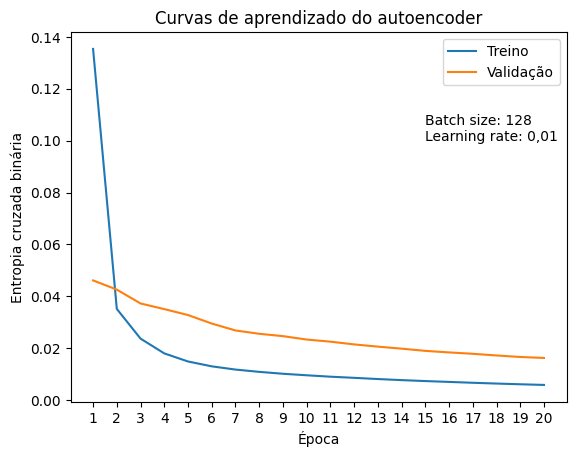

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.plot()
plt.title("Curvas de aprendizado do autoencoder")
plt.xlabel("Época")
plt.ylabel("Entropia cruzada binária")
plt.legend(["Treino", "Validação"])
plt.xticks(range(20), range(1,21))
plt.annotate("Batch size: 128\nLearning rate: 0,01", (14,0.1))
plt.show()

### Conjunto de teste



In [ ]:
x_train_complete = np.concatenate((x_train, x_val), axis=0)
x_train_complete.shape

(7108, 21771)

In [ ]:
dropout_rate = 0.2
epochs = 20
for batch_size in ([128]):
  for learning_rate in [0.01]:

    input_shape = x.shape[1]

    input_layer = Input(shape=(input_shape,))

    dropout_layer = Dropout(rate=dropout_rate, seed=42)(input_layer)

    encoded = Dense(64, activation="relu")(dropout_layer)
    decoded = Dense(input_shape, activation="sigmoid")(encoded)

    autoencoder = Model(input_layer, decoded)

    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy")

    history = autoencoder.fit(x_train_complete, x_train_complete, epochs=epochs, batch_size=batch_size)

    path = f'/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/dae/b{batch_size}_lr{learning_rate}_e{epochs}do{dropout_rate}_completeTrain'
    autoencoder.save(path)
    pd.DataFrame(history.history).to_csv(f'{path}/history.csv')

    predicted_test = autoencoder.predict(x_test_hidden)

    predicted_test_df = pd.DataFrame(predicted_test.T)
    predicted_test_df.columns = ["P" + str(col) for col in rows_to_test]

    true_test_df = pd.DataFrame(x_test.T)
    true_test_df.columns = ["P" + str(col) for col in rows_to_test]

    hidden_test_df = pd.DataFrame(x_test_hidden.T)
    hidden_test_df.columns = ["P" + str(col) for col in rows_to_test]

    test_results = []

    for col in tqdm(true_test_df.columns):
      true_tracks = np.array(true_test_df[true_test_df[col] == 1.0].index)
      unhidden_tracks = np.array(hidden_test_df[hidden_test_df[col] == 1.0].index)
      hidden_tracks = np.array([t for t in true_tracks if t not in unhidden_tracks])

      number_of_hidden_tracks = len(hidden_tracks)

      ordered_predicted_tracks = np.array(predicted_test_df[[col]].sort_values(col, ascending=False).index)

      ordered_predicted_tracks = [t for t in ordered_predicted_tracks if t not in unhidden_tracks]

      selected_tracks = ordered_predicted_tracks[:number_of_hidden_tracks]

      #Compute clicks
      i = 0
      for track in ordered_predicted_tracks:
        if track not in hidden_tracks:
          i+=1
        else:
          break

      #Compute recall
      tp=0
      for t in selected_tracks:
        if t in hidden_tracks:
          tp+=1

      dict_to_append = {
          "playlist": col,
          "clicks": i,
          "recall": tp/number_of_hidden_tracks,
          "n_hidden": number_of_hidden_tracks,
          }

      test_results.append(dict_to_append)
test_results_df = pd.DataFrame(test_results)

In [ ]:
path = f'/content/drive/MyDrive/UFSC/Semestre24_1/AprendizadoDeMaquinas/Trabalho-final/modelos/dae'

test_results_df.to_pickle(f"{path}/test_results.pkl")

In [ ]:
test_results_df

,playlist,clicks,recall,plist_id,n_hidden
0,P2,1493,0.000000,2,6
1,P3,87,0.000000,3,4
2,P4,0,0.214286,4,14
3,P6,24,0.000000,6,5
4,P10,2,0.166667,10,12
...,...,...,...,...,...
1772,P8872,6,0.125000,8872,16
1773,P8874,18,0.000000,8874,6
1774,P8877,0,0.200000,8877,5
1775,P8879,6,0.000000,8879,5


In [ ]:
print("DAE TEST RESULTS")
print(15*"-")
print(f"Mean recall: {test_results_df['recall'].mean():.3f}")
print(f"Mean clicks: {test_results_df['clicks'].mean():.3f}")


DAE TEST RESULTS
---------------
Mean recall: 0.096
Mean clicks: 145.948
